# Revealing the Spatial Shifting Patterns of COVID-19 Pandemic in the United States.
### Di Zhu, Xinyue Ye, Steven Manson (2021), Scientific Reports. DOI : 10.1038/s41598-021-87902-8 b1496e8c-d2f6-44a0-ad87-06c43bad8ca8
#### reference: Di Zhu, Zhou Huang, Li Shi, Lun Wu & Yu Liu (2018) Inferring spatial interaction patterns from sequential snapshots of spatial distributions, International Journal of Geographical Information Science, 32:4, 783-805, DOI: 10.1080/13658816.2017.1413192 https://doi.org/10.1080/13658816.2017.1413192 and the demo code in https://github.com/dizhu-gis/IIDS-Inferring_Interactions_from_Distribution_Snapshots
© Copyright 2021, Di Zhu 

In [1]:
from pulp import *

In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import numpy as np
import libpysal as lp
import seaborn as sns
import matplotlib.pyplot as plt
from splot.libpysal import plot_spatial_weights
import copy

In [3]:
import matplotlib.colors as colors
import networkx as nx
import matplotlib as mpl

In [4]:
from matplotlib import cm

In [5]:
sns.set_context('poster')

In [6]:
state=gpd.read_file('./COUNTY_dis2/COUNTY_dis2.shp')
# state.head(5)

In [7]:
columns=['STATE_FIPS','STATE_NAME','SUM_POP2_1','geometry']

state_df=state[columns]
state_df=state_df.dropna()

In [8]:
pop_gdp=pd.read_csv('./COUNTY_dis2/state_pop_GDP_2019.csv')
pop_gdp.columns=['Name','Postal Code','FIPS','POP2019','GDP2019million']

In [9]:
pop_gdp.head()

,Name,Postal Code,FIPS,POP2019,GDP2019million
0,Alabama,AL,1,4903185.0,230968.2
1,Alaska,AK,2,731545.0,55406.1
2,Arizona,AZ,4,7278717.0,366189.9
3,Arkansas,AR,5,3017804.0,133180.9
4,California,CA,6,39512223.0,3137469.0


In [10]:
state_df=state_df.merge(pop_gdp,left_on='STATE_NAME',right_on='Name',how='inner')[['STATE_FIPS','STATE_NAME','geometry','SUM_POP2_1','POP2019','GDP2019million']]
state_df.head()

,STATE_FIPS,STATE_NAME,geometry,SUM_POP2_1,POP2019,GDP2019million
0,01,Alabama,"POLYGON ((781138.392 -994463.795, 785035.721 -...",4663715.0,4903185.0,230968.2
1,04,Arizona,"POLYGON ((-1091411.402 -254947.992, -1107226.8...",6363799.0,7278717.0,366189.9
2,05,Arkansas,"POLYGON ((483079.620 -418703.650, 478371.088 -...",2889091.0,3017804.0,133180.9
3,06,California,"MULTIPOLYGON (((-1981746.095 -531278.852, -196...",37483448.0,39512223.0,3137469.0
4,08,Colorado,"POLYGON ((-582926.746 134757.217, -525361.353 ...",4883413.0,5758736.0,390283.9


Input the entry of two snapshots

In [261]:
t1='07-23'
t2='08-09'

In [262]:
covdf1=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t1+'_2020.csv')
covdf2=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t2+'_2020.csv')

In [263]:
columns_2=['FIPS','Province_State','Confirmed','Deaths']
covdf1=covdf1[columns_2]
covdf2=covdf2[columns_2]

confirmed1=state_df.merge(covdf1,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
death1=state_df.merge(covdf1,left_on='STATE_NAME',right_on='Province_State',how="inner")['Deaths']
confirmed2=state_df.merge(covdf2,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
death2=state_df.merge(covdf2,left_on='STATE_NAME',right_on='Province_State',how="inner")['Deaths']

state_df['confirmed1']=confirmed1
state_df['confirmed2']=confirmed2
state_df['death1']=death1
state_df['death2']=death2
state_df.head()

,STATE_FIPS,STATE_NAME,geometry,SUM_POP2_1,POP2019,GDP2019million,confirmed1,confirmed2,death1,death2,confirmed1_scaled
0,01,Alabama,"POLYGON ((781138.392 -994463.795, 785035.721 -...",4663715.0,4903185.0,230968.2,74212,101334,1397,1768,45394.108786
1,04,Arizona,"POLYGON ((-1091411.402 -254947.992, -1107226.8...",6363799.0,7278717.0,366189.9,153029,187086,3067,4152,62641.684372
2,05,Arkansas,"POLYGON ((483079.620 -418703.650, 478371.088 -...",2889091.0,3017804.0,133180.9,36259,49383,386,544,21491.909855
3,06,California,"MULTIPOLYGON (((-1981746.095 -531278.852, -196...",37483448.0,39512223.0,3137469.0,433175,563244,8190,10365,285556.663583
4,08,Colorado,"POLYGON ((-582926.746 134757.217, -525361.353 ...",4883413.0,5758736.0,390283.9,42409,50799,1788,1863,56893.154860


Transform the data to the same scale

In [264]:
scalar=confirmed1.sum()/confirmed2.sum()
state_df['confirmed1_scaled']=confirmed1/scalar
state_df.confirmed2.sum(),state_df.confirmed1_scaled.sum()
state_df.sort_values('confirmed2',ascending=False).head()

,STATE_FIPS,STATE_NAME,geometry,SUM_POP2_1,POP2019,GDP2019million,confirmed1,confirmed2,death1,death2,confirmed1_scaled
3,06,California,"MULTIPOLYGON (((-1981746.095 -531278.852, -196...",37483448.0,39512223.0,3137469.0,433175,563244,8190,10365,539715.716205
8,12,Florida,"MULTIPOLYGON (((1531277.835 -1513895.284, 1512...",18893813.0,21477737.0,1093350.7,389860,532798,5517,8185,485747.259467
41,48,Texas,"MULTIPOLYGON (((-113972.168 -1543309.926, -114...",23986432.0,28995881.0,1886956.1,376104,508190,4714,8978,468607.929192
30,36,New York,"MULTIPOLYGON (((1720074.545 263934.468, 171684...",19581872.0,19453561.0,1731910.4,414405,425568,32270,32354,516329.177293
9,13,Georgia,"MULTIPOLYGON (((1327278.751 -898577.464, 13264...",9654958.0,10617423.0,616333.3,143857,200147,3288,4108,179239.069166


Text(0.5, 1.0, 'After: 08-09')

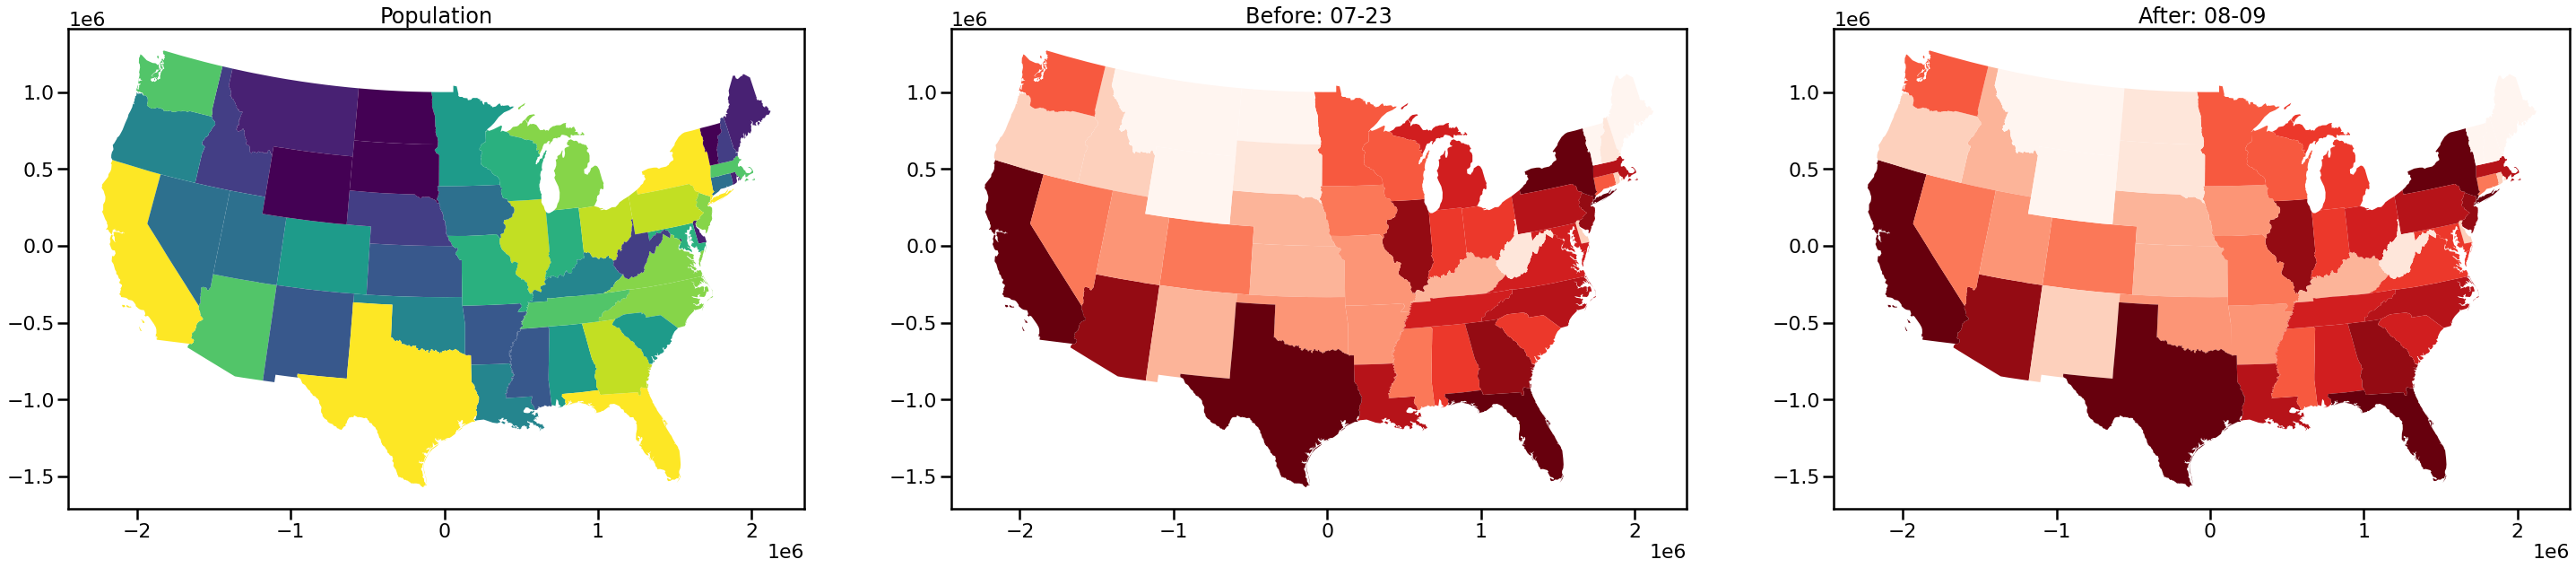

In [265]:
f,ax=plt.subplots(1,3,figsize=(50,200))
state_df.plot(column='POP2019',scheme='Quantiles',k=12,legend=False,ax=ax[0])
state_df.plot(column='confirmed1_scaled',scheme='Quantiles',k=12,cmap='Reds',legend=False,ax=ax[1])
state_df.plot(column='confirmed2',scheme='Quantiles',k=12,cmap='Reds',legend=False,ax=ax[2])
ax[0].set_title('Population')
ax[1].set_title('Before: '+t1)
ax[2].set_title('After: '+t2)
# plt.savefig('./Fig_results/19POP/distributions/'+t1+'_to_'+t2+'distribution.png',dpi=200,bbox_inches='tight')

Generate cost_matrix

##### Loading Twitter movements

In [266]:
twitter_mat=np.loadtxt('./movementmatricesbetweenstates/FormattedTwitterOD/2020.'+t1+'~'+t2+'.csv',delimiter=',',skiprows=0)
twitter_mat=twitter_mat.astype(int)

/Users/zhudi/miniconda3/envs/myconda/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


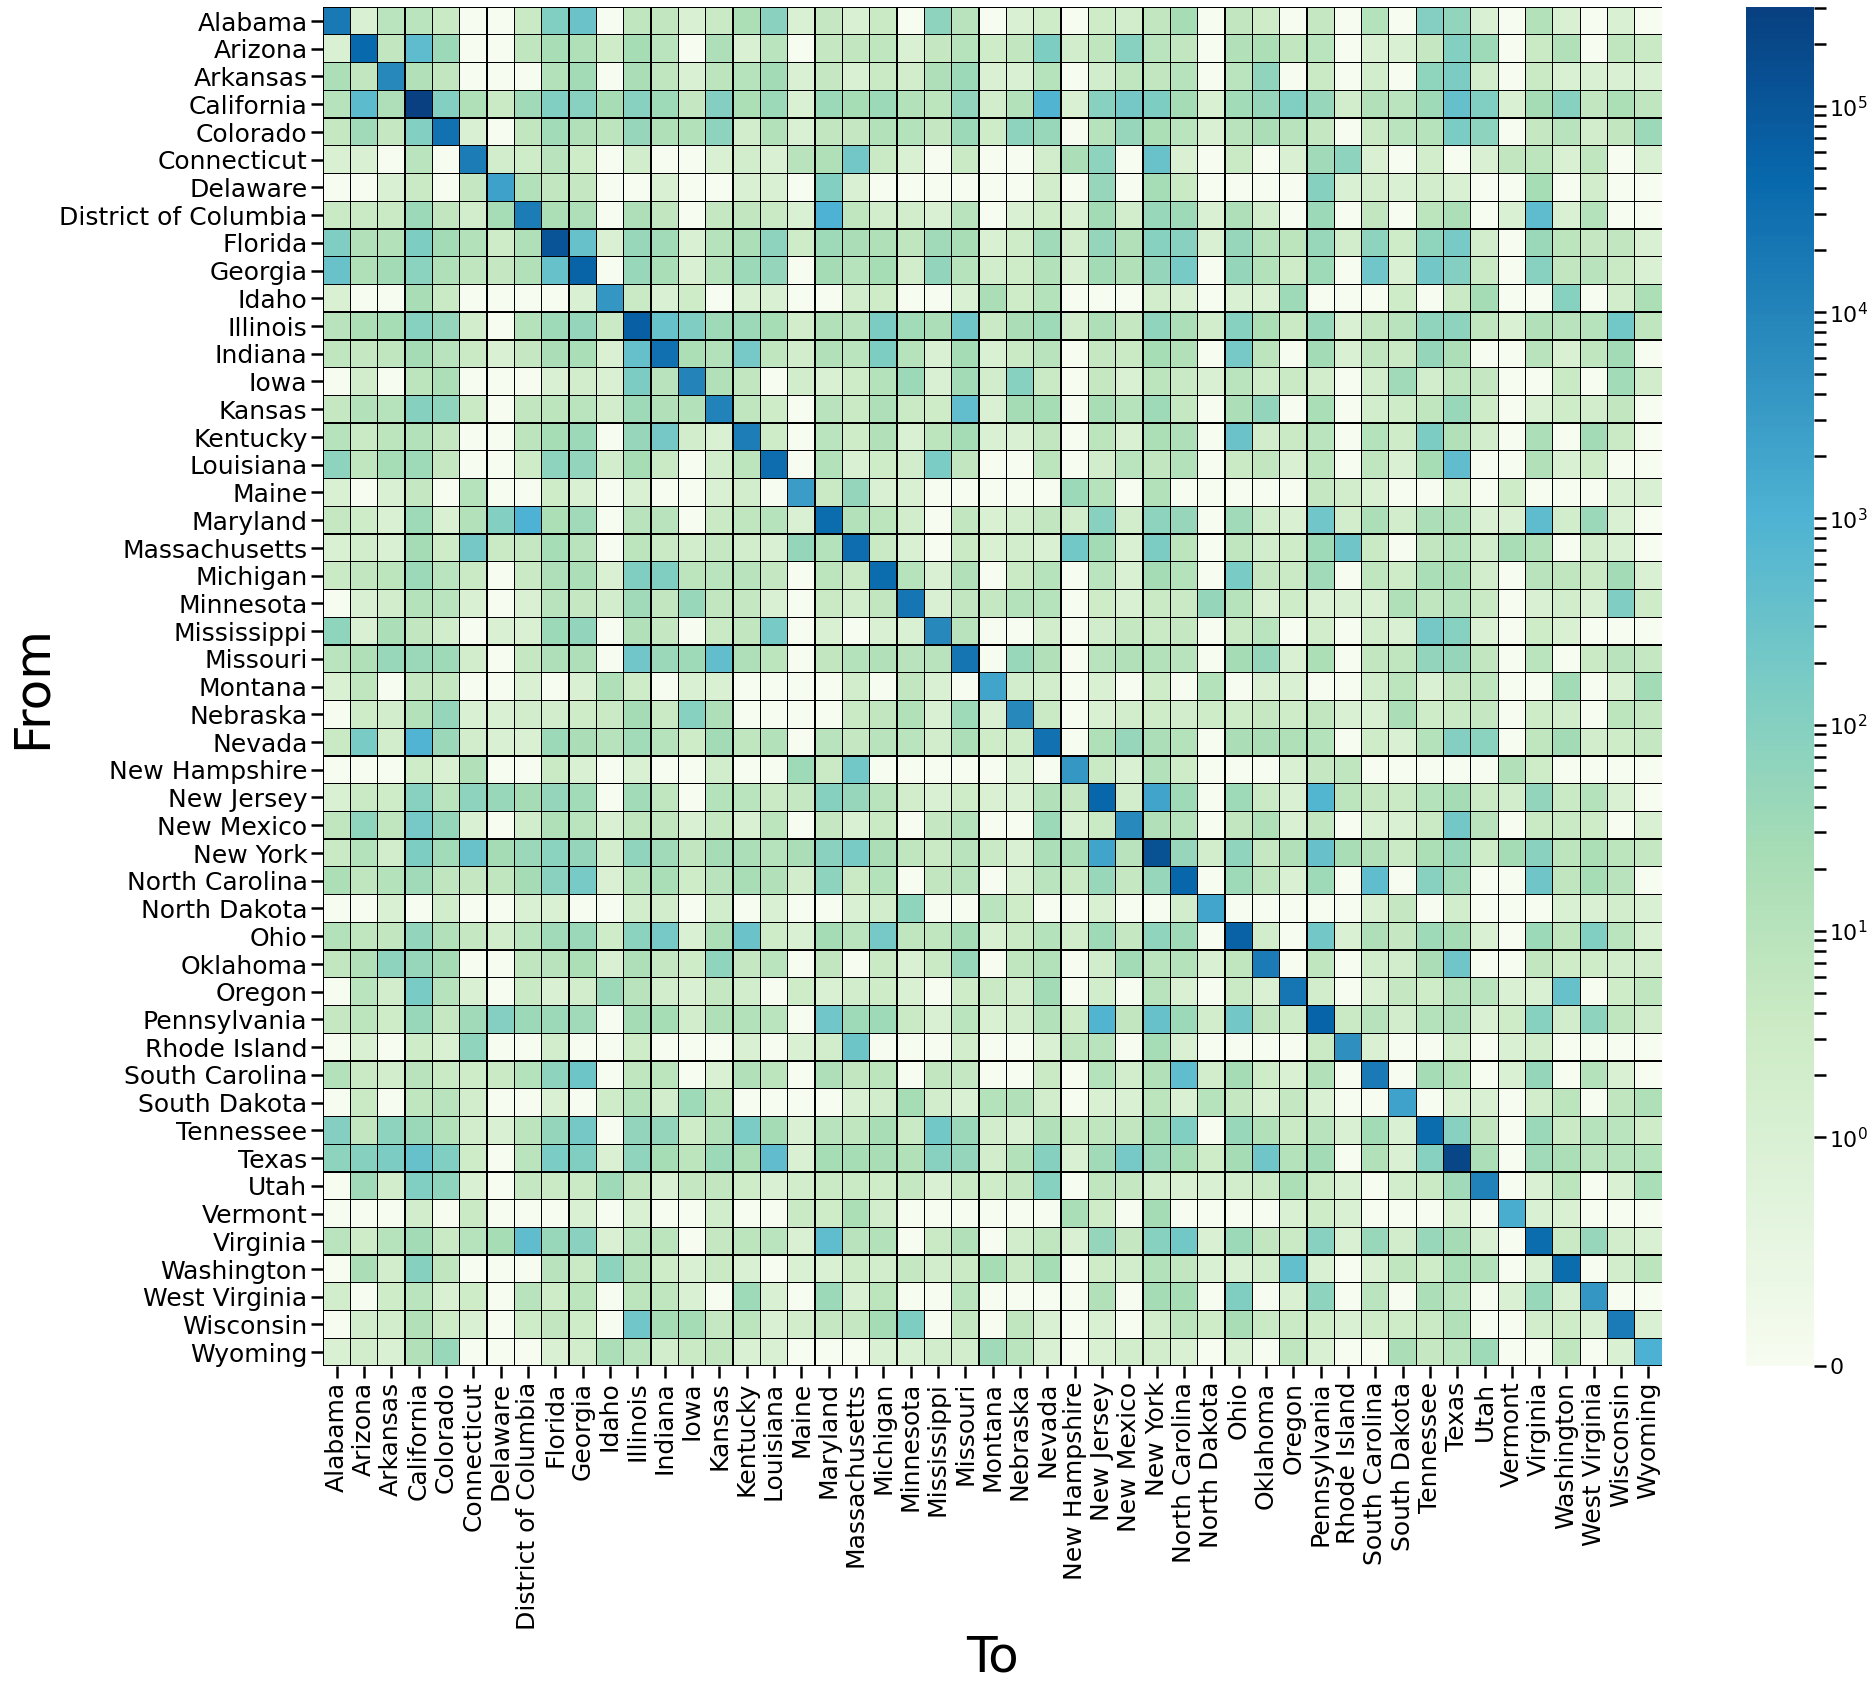

In [268]:
f,ax=plt.subplots(1,1,figsize=(30,25))

w = lp.weights.full2W(twitter_mat)

sns.heatmap(w.full()[0],ax=ax,cmap='GnBu',linecolor='black',linewidths=.3,cbar = True,norm=colors.SymLogNorm(linthresh=1, linscale=1, base=10))

ax.set_xticklabels(state.STATE_NAME.values,rotation=90,fontsize=25)
ax.set_yticklabels(state.STATE_NAME.values,rotation=0,fontsize=25)
# ax[1].set_title(t1+' to '+t2,fontsize=20)
ax.set_ylabel('From',fontsize=50)
ax.set_xlabel('To',fontsize=50)
# plt.savefig('./Fig_results_twitter/TwitterOD_'+t1+'_'+t2+'_Mat.png',dpi=200,bbox_inches='tight')
plt.show()

## cost_matrix computing method！
#### Gravity model with twitter data modified

In [269]:
# Distance coefficient
beta=0.8
epsilon=10 #smaller eps(<10) will escalate the segregation(cost) between states where no twitter move happened. 
# read distance matrix
distance=np.genfromtxt('distancematrix_states/matrix_states.csv',delimiter=',',dtype=None)
# read node attractions
attraction=np.array(state_df['GDP2019million'])

# Ci_j=pow(distance,beta)/(Ai*Aj)
cost=copy.deepcopy(distance)

############twitter movements + 1 ）+eps to avoid 0 values
w = lp.weights.full2W(twitter_mat)
twitter_weights=np.log10(w.full()[0]+epsilon)

N=int(distance.shape[0])
for i in range(0,N):
    for j in range(0,N):
#         cost[i][j]=pow(10,9)*pow(float(distance[i][j]),beta)/(float(attraction[i])*float(attraction[j]))#for gdp
        cost[i][j]=pow(10,8)*pow(float(distance[i][j]),beta)/(float(attraction[i])*float(attraction[j]))/twitter_weights[i][j] #for pop+twitter

    # save file
out= open("./movementmatricesbetweenstates/TwitterDerivedCostMatrix_new/Cost_Matrix_twitter_"+t1+'_'+t2+".csv","w")
for i in range(0,N):
    for j in range(0,N):
        if j!=N-1:
            out.write(str(cost[i][j])+',')
        else:
            out.write(str(cost[i][j])+'\n')
out.close()

In [270]:
# load file
cost_matrix=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix_new/Cost_Matrix_twitter_"+t1+'_'+t2+".csv",delimiter=',',skiprows=0)

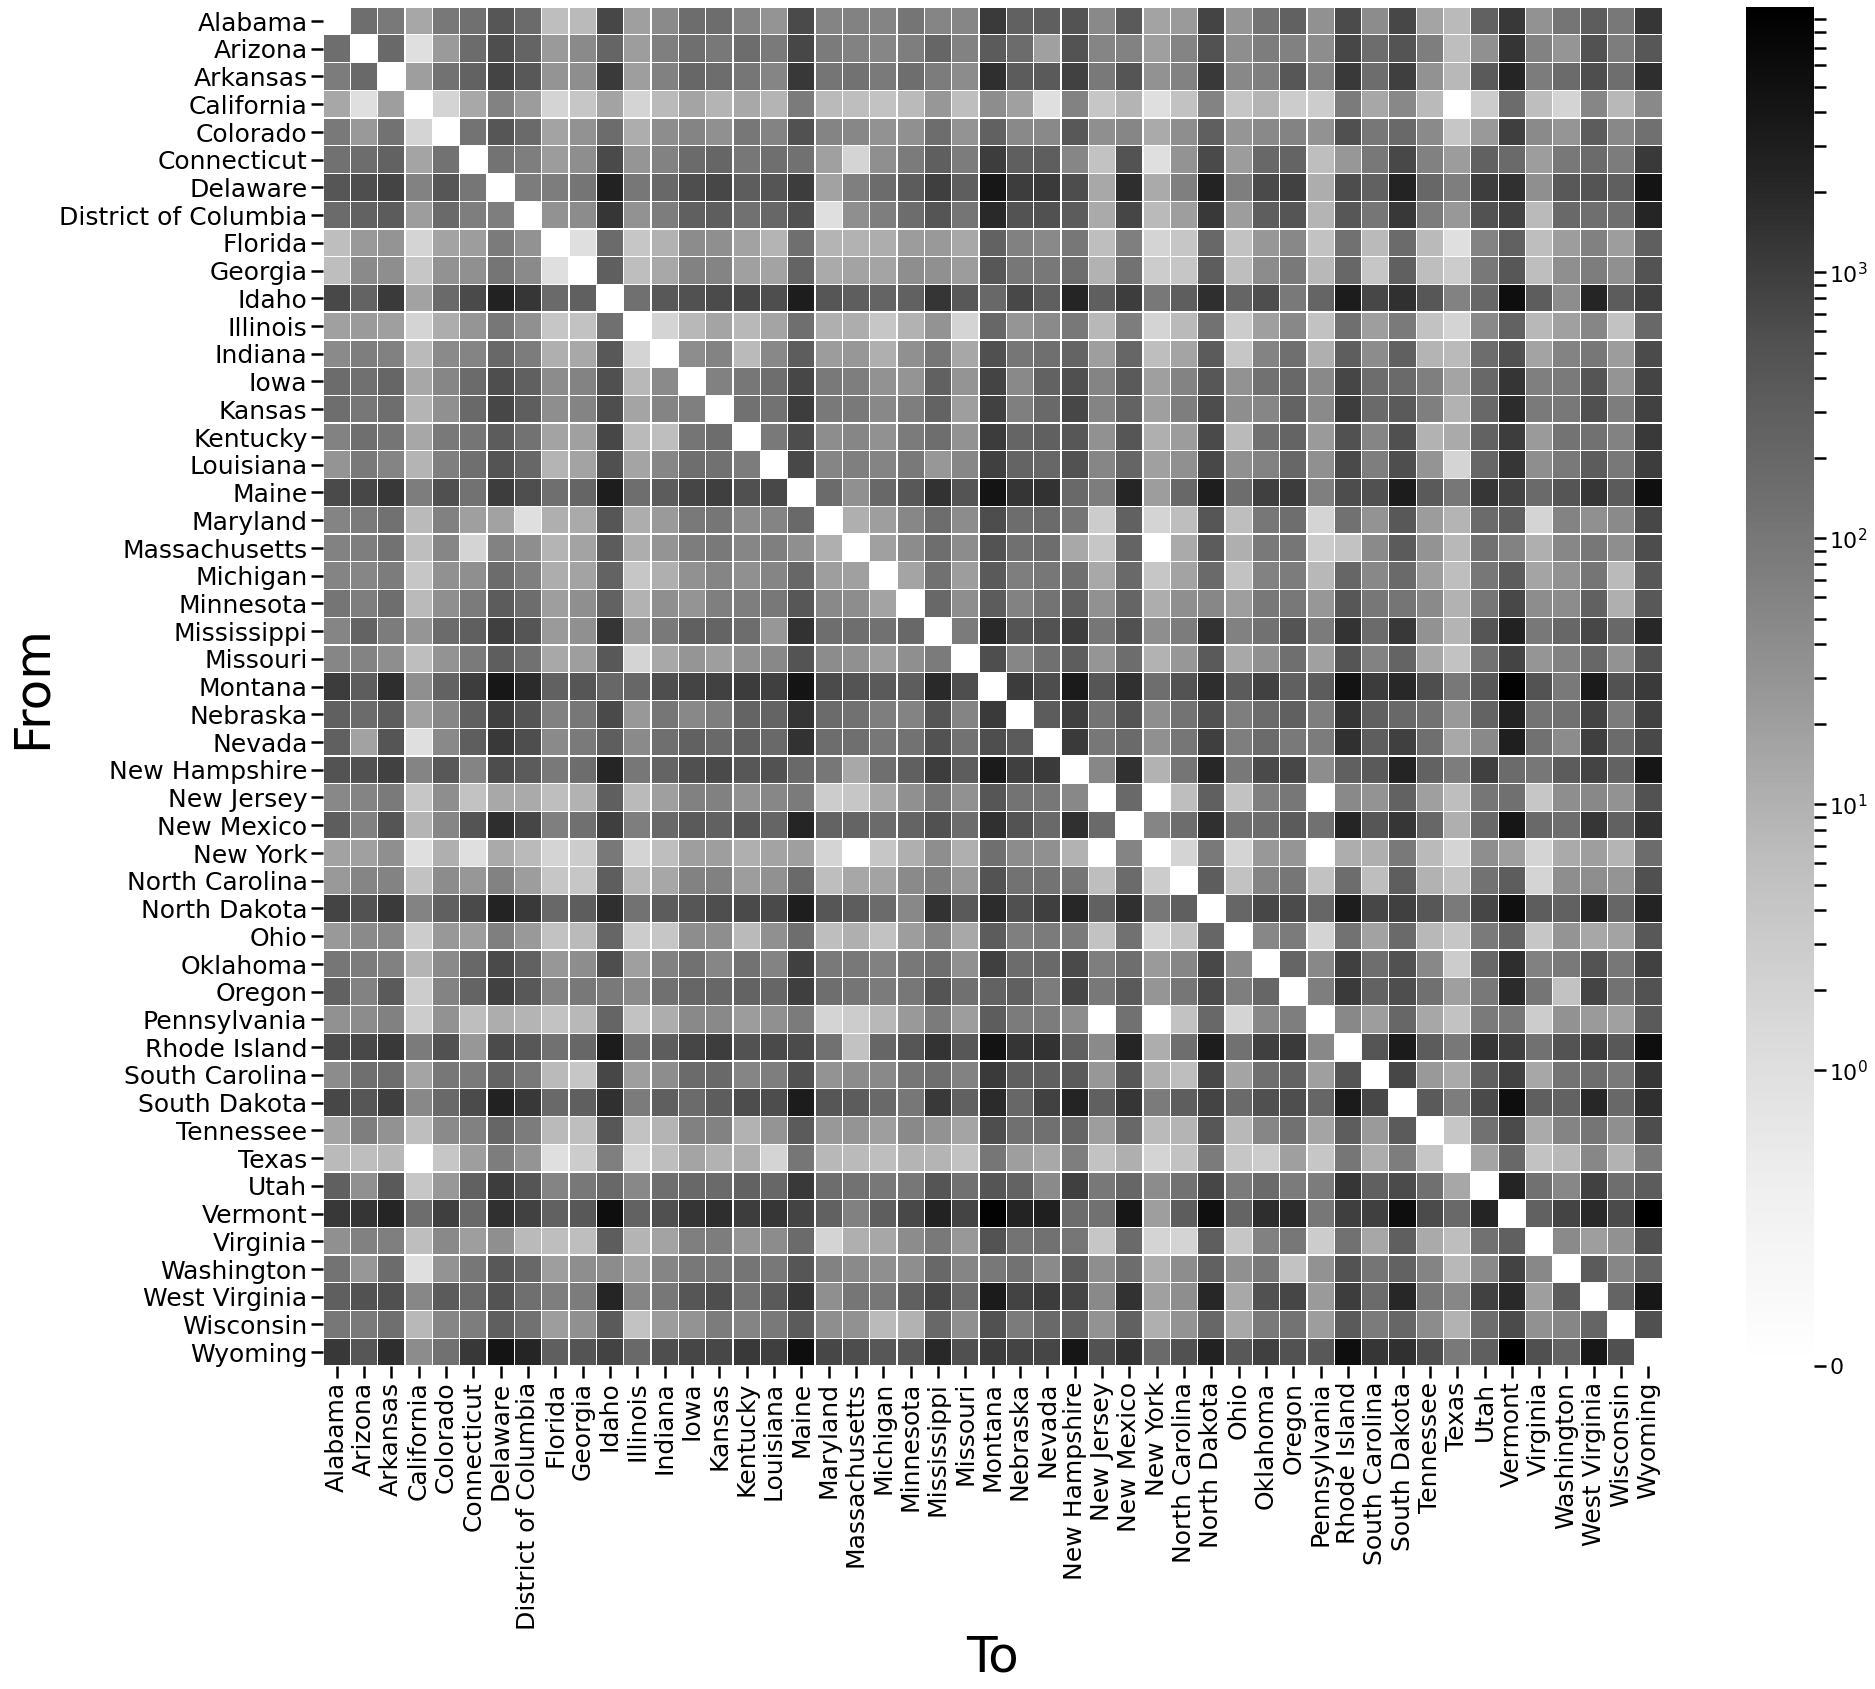

In [271]:
f,ax=plt.subplots(1,1,figsize=(30,25))
sns.heatmap(cost_matrix,ax=ax,cmap='Greys',linecolor='white',linewidths=.3,cbar = True,norm=colors.SymLogNorm(linthresh=1, linscale=1, base=10))

ax.set_xticklabels(state.STATE_NAME.values,rotation=90,fontsize=25)
ax.set_yticklabels(state.STATE_NAME.values,rotation=0,fontsize=25)
# ax[1].set_title(t1+' to '+t2,fontsize=20)
ax.set_ylabel('From',fontsize=50)
ax.set_xlabel('To',fontsize=50)
# plt.savefig('./Fig_results_twitter/TwitterOD_'+t1+'_'+t2+'_twittergravitycost_hm.png',dpi=200,bbox_inches='tight')
plt.show()

## IIDS Modelling and Computation

In [273]:
# city_ids
states=[]
for i in range(0,state_df.shape[0]):
    states.append(str(i))
    
# cost    
cost_matrix=cost_matrix.tolist()

#variations
# the variation for each city "key ~ value": "city_id ~ change_num"
variations={}
for i in states:
    change=state_df.confirmed2[int(i)]-state_df.confirmed1_scaled[int(i)]
    variations[i]=change

In [274]:
#declare problem
prob = LpProblem("IIDS_USCov2020", LpMinimize)

# Creates a list of tuples containing all the possible flows for movements
flows = [(o,d) for o in states for d in states]

# A dictionary called flow_vars is created to contain the referenced variables (the flows)
flow_vars = LpVariable.dicts("flow",(states,states),0,None) # n*n
#call flow_vars['2']['1'] # flow_2_1 means flow from state 1 to state 2

# The objective func
prob += lpSum([flow_vars[o][d]*cost_matrix[int(o)][int(d)] for (o,d) in flows]), "Sum of movement costs"

# The subjective func for each city
# The constraints are added to make it consist for all cities
# since after data is not exactly the same as before data due to float/int convertion, the constraints can be >= or <= depending on the data
for c in states:
    prob += lpSum([flow_vars[x][c] for x in states]) - lpSum([flow_vars[c][x] for x in states]) >= variations[c], "Sum of in/outflow of state %s"%c

In [275]:
# solve the LP
prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [276]:
# print the results
print(t1+' '+t2)
for v in prob.variables():
    if v.varValue!=0.0:
        print(v.name, "=", v.varValue)
print("Total Cost of movements: ", value(prob.objective))

07-23 08-09
flow_11_15 = 4104.9575
flow_11_23 = 10123.816
flow_11_40 = 2059.6413
flow_12_15 = 30.566873
flow_13_11 = 1910.901
flow_17_30 = 614.12658
flow_18_30 = 7014.518
flow_19_30 = 24678.336
flow_1_3 = 3580.9506
flow_20_3 = 3987.3815
flow_20_33 = 1718.9686
flow_20_47 = 2847.5894
flow_21_32 = 750.99604
flow_25_3 = 1244.11
flow_27_30 = 1040.9314
flow_28_30 = 37405.082
flow_29_3 = 315.24541
flow_30_3 = 111380.53
flow_30_31 = 1680.1007
flow_30_8 = 47050.741
flow_30_9 = 25895.451
flow_33_46 = 778.96052
flow_36_30 = 14461.165
flow_37_19 = 2873.5561
flow_39_3 = 540.79576
flow_3_10 = 3787.7395
flow_3_14 = 596.72291
flow_3_21 = 936.07894
flow_3_24 = 1308.8333
flow_3_26 = 6330.2338
flow_3_35 = 1629.55
flow_3_41 = 85653.812
flow_3_45 = 141.72292
flow_3_48 = 125.74817
flow_41_0 = 8869.3316
flow_41_16 = 4726.3248
flow_41_2 = 4205.988
flow_41_22 = 7301.2177
flow_41_34 = 8712.9389
flow_41_40 = 12255.94
flow_42_3 = 949.08976
flow_43_30 = 256.67736
flow_44_31 = 1131.4886
flow_4_3 = 2040.6233
flow_5_